**Our main goal:** Define a neural net architecture that is capable of accurate periodic signal `sin(2x) + sin(x)` prediction (a.k.a. regression task) and are not input value range dependent (work in all ranges of `x`).

Importing libraries

In [ ]:
import os
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras #we will be using keras module only
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping 
import matplotlib.pyplot as plt
from datetime import date
%matplotlib inline

Visualising the `sin(2x) + sin(x)` signal 

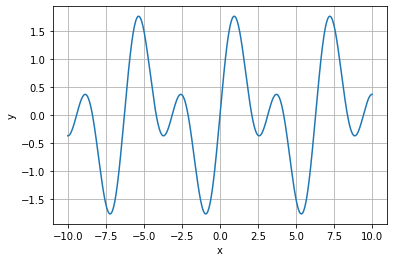

In [ ]:
x = np.linspace(-10,10,1000)
y = np.sin(2*x) + np.sin(x)

plt.plot(x,y)
plt.ylabel('y')
plt.xlabel('x')

plt.grid()
plt.show()

Defining few model architectures

In [ ]:
# Using a periodic activation function
def sin_activation(x):
    # return keras.backend.sin(x)
    return tf.math.sin(x)

In [ ]:
def get_model():
    input = keras.layers.Input(shape=(1,), dtype="float32", name="input")
    x = keras.layers.Dense(2, use_bias=False, activation=sin_activation, name="dense_1")(input)
    output = keras.layers.Dense(1, use_bias=False, activation=None, name="dense_2")(x)
    return keras.Model(inputs=[input], outputs=[output])

Visualizing the architectures

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 1)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 2         
Total params: 4
Trainable params: 4
Non-trainable params: 0
_________________________________________________________________


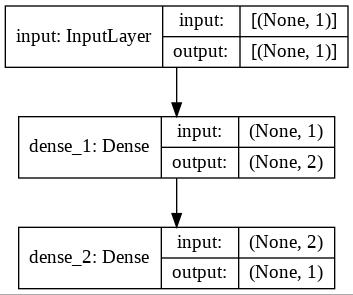

In [ ]:
model = get_model()
model.summary()
keras.utils.plot_model(model, to_file="model_arch.jpg",
                       show_shapes=True,
                       show_layer_names=True,
                       rankdir="TB",
                       dpi=96)

Compiling the models

In [ ]:
opt = keras.optimizers.Adam()
loss = keras.losses.MeanSquaredError()
metric_mae = keras.metrics.MeanAbsoluteError()

model.compile(optimizer=opt,
              loss=loss,
              metrics=[metric_mae],
              run_eagerly=False,)

Definig usefull callbacks

In [ ]:
model_path = 'model_'+str(date.today())
if not os.path.exists(model_path): 
  os.mkdir(model_path)

checkpoint_path = os.path.join(model_path,'model.h5')

callbacks = [
  ModelCheckpoint(filepath=checkpoint_path, monitor="val_loss", verbose=1, save_best_only=True),
  EarlyStopping( monitor="val_loss", patience=2, verbose=1)
]

Making train/val data sets

In [ ]:
def shuffled_copies(a, b): #both arrays should have the same length
    p = np.random.permutation(len(a)) #get shuffled indexes
    return a[p], b[p]

In [ ]:
x_long = np.linspace(-np.pi, np.pi, num=10000)
y_long = np.sin(2*x_long) + np.sin(x_long)
x_long_shuffled, y_long_shuffled = shuffled_copies(x_long, y_long)

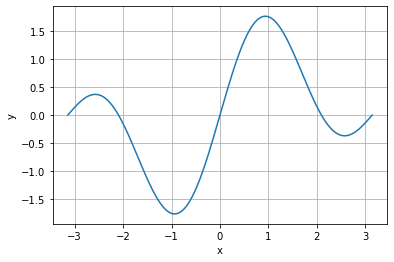

In [ ]:
plt.plot(x_long,y_long)
plt.ylabel('y')
plt.xlabel('x')

plt.grid()
plt.show()

Training `model_1`

In [ ]:
batch_size = 4
epochs = 10

history = model.fit(x_long_shuffled,
           y_long_shuffled,
           batch_size=batch_size,
           epochs=epochs,
           callbacks = callbacks,
           validation_split=0.1);

Epoch 1/10
2250/2250 [==============================] - 3s 1ms/step - loss: 0.0849 - mean_absolute_error: 0.1967 - val_loss: 4.4301e-05 - val_mean_absolute_error: 0.0049

Epoch 00001: val_loss improved from inf to 0.00004, saving model to model_2021-11-02/model.h5
Epoch 2/10
2250/2250 [==============================] - 3s 1ms/step - loss: 2.6510e-05 - mean_absolute_error: 0.0041 - val_loss: 1.7579e-05 - val_mean_absolute_error: 0.0033

Epoch 00002: val_loss improved from 0.00004 to 0.00002, saving model to model_2021-11-02/model.h5
Epoch 3/10
2250/2250 [==============================] - 3s 1ms/step - loss: 7.4747e-06 - mean_absolute_error: 0.0021 - val_loss: 2.2731e-06 - val_mean_absolute_error: 9.6670e-04

Epoch 00003: val_loss improved from 0.00002 to 0.00000, saving model to model_2021-11-02/model.h5
Epoch 4/10
2250/2250 [==============================] - 2s 1ms/step - loss: 3.3850e-07 - mean_absolute_error: 3.5562e-04 - val_loss: 1.3015e-09 - val_mean_absolute_error: 2.7834e-05

Ep

Visualing training stats

In [ ]:
print(history.params)
print(history.history.keys())

{'verbose': 1, 'epochs': 10, 'steps': 2250}
dict_keys(['loss', 'mean_absolute_error', 'val_loss', 'val_mean_absolute_error'])


In [ ]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_mae = history.history['mean_absolute_error']
val_mae = history.history['val_mean_absolute_error']
epochs = range(1,len(train_loss)+1)

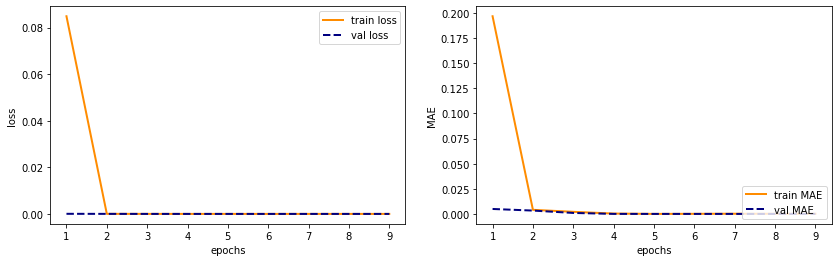

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(14,4))

ax[0].plot(epochs, train_loss, color='darkorange', lw=2, label='train loss')
ax[0].plot(epochs, val_loss, color='navy', lw=2, linestyle='--', label='val loss')
# ax[0].set_ylim([0.15, 1.0])
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('loss')
ax[0].legend(loc="upper right")

ax[1].plot(epochs, train_mae, color='darkorange', lw=2, label='train MAE')
ax[1].plot(epochs, val_mae, color='navy', lw=2, linestyle='--', label='val MAE')
# ax[1].set_ylim([0.95, 1.0])
ax[1].set_xlabel('epochs')
ax[1].set_ylabel('MAE')
ax[1].legend(loc="lower right")

Checking model weights

In [ ]:
model.get_weights()

[array([[-0.9999904,  2.0000262]], dtype=float32), array([[-0.99999774],
        [ 0.9999552 ]], dtype=float32)]

Making regression predictions

At small ranges:

In [ ]:
x_test = np.linspace(-100*np.pi, -97*np.pi, num=10000)
y_test = np.sin(2*x_test) + np.sin(x_test)
y_pred = model.predict(x_test)

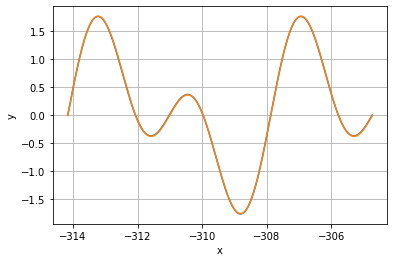

In [ ]:
plt.plot(x_test,y_test,x_test,y_pred)
plt.ylabel('y')
plt.xlabel('x')

plt.grid()
plt.show()

Farther away:

In [ ]:
x_test = np.linspace(-2000*np.pi, -1997*np.pi, num=10000)
y_test = np.sin(2*x_test) + np.sin(x_test)
y_pred = model.predict(x_test)

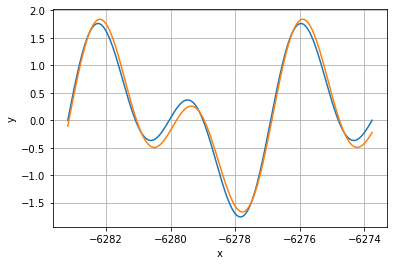

In [ ]:
plt.plot(x_test,y_test,x_test,y_pred)
plt.ylabel('y')
plt.xlabel('x')

plt.grid()
plt.show()

**Conclusions:** 
* We have accomplished our goal of fitting a periodic signal with a model architecture that contains only 4 weights.
* As can be seen, the prediction accuracy directly depends on the accuracy of the weights in the first layer. They accuracy can be improved by lowering the learning rate, setting double precission and so on ...

In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [36]:
# Convert .ipynb to .html in the Colab enviroment
%%shell
jupyter nbconvert --to html drive/MyDrive/VGTU/Deep_Learning_Systems/Lab1.ipynb

[NbConvertApp] Converting notebook drive/MyDrive/VGTU/Deep_Learning_Systems/Lab1.ipynb to html
[NbConvertApp] Writing 456009 bytes to drive/MyDrive/VGTU/Deep_Learning_Systems/Lab1.html
